# Science Validation Surveys

During LSST's Science Validation Surveys, the project is [providing databases](https://survey-strategy.lsst.io/progress/sv_status) containing information on the observations obtained so far in the same format as the MAF OpSim databases.  

The purpose of this notebook is to examine the observations made to date. 

In [1]:
from os import path
import rubin_sim.maf as maf
import numpy as np 
import sqlite3 
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt

NSIDE = 64

## Load SV Observations Database

New databases are posted after each successful night of observations with filenames that indicate the date of the update.  
Each database contains information on the accumulated observations up to that date. 

In [2]:
# UPDATE THIS TO THE LATEST DB
DATA_DIR = '/Users/rstreet/LSST/SCOC/SV' 
DB_FILE = 'sv_20250729.db'

ops_db_path = path.join(DATA_DIR, DB_FILE)

run_name = path.split(path.basename(ops_db_path))[-1].replace('.db', '')

There may be some differences in the SV ops_db formats compared with the op_sims, so let's inspect the SV database columns.

In [3]:
db = sqlite3.connect(ops_db_path)
table = pd.read_sql_query("SELECT * from observations limit 2", db)
for col in table.columns:
    print(col)

observationId
exposure_name
controller
day_obs
seq_num
physical_filter
band
fieldRA
fieldDec
rotSkyPos
azimuth_start
azimuth_end
azimuth
altitude_start
altitude_end
altitude
zenith_distance_start
zenith_distance_end
zenith_distance
airmass
exp_midpt
exp_midpt_mjd
obs_start
observationStartMJD
obs_end
obs_end_mjd
visitExposureTime
shut_time
visitTime
group_id
cur_index
max_index
img_type
emulated
science_program
observation_reason
target_name
air_temp
pressure
humidity
wind_speed
wind_dir
dimm_seeing
focus_z
simulated
vignette
vignette_min
scheduler_note
s_region
can_see_sky
n_inputs
pixel_scale_min
pixel_scale_max
pixel_scale_median
astrom_offset_mean_min
astrom_offset_mean_max
astrom_offset_mean_median
astrom_offset_std_min
astrom_offset_std_max
astrom_offset_std_median
eff_time_min
eff_time_max
eff_time_median
eff_time_psf_sigma_scale_min
eff_time_psf_sigma_scale_max
eff_time_psf_sigma_scale_median
eff_time_sky_bg_scale_min
eff_time_sky_bg_scale_max
eff_time_sky_bg_scale_median
eff_t

Based on the [MAF tutorials](https://github.com/lsst/rubin_sim_notebooks/tree/main/maf/tutorial) this should calculate the number of visits as a function of HEALpixels.  

In [4]:
gvisits_metric_bundle = maf.MetricBundle(
    metric=maf.CountMetric(col='night', metric_name='Nvisits'),
    slicer=maf.HealpixSlicer(nside=NSIDE),
    constraint="band='g'",
    run_name=run_name,
)
rvisits_metric_bundle = maf.MetricBundle(
    metric=maf.CountMetric(col='night', metric_name='Nvisits'),
    slicer=maf.HealpixSlicer(nside=NSIDE),
    constraint="band='r'",
    run_name=run_name,
)
ivisits_metric_bundle = maf.MetricBundle(
    metric=maf.CountMetric(col='night', metric_name='Nvisits'),
    slicer=maf.HealpixSlicer(nside=NSIDE),
    constraint="band='i'",
    run_name=run_name,
)
zvisits_metric_bundle = maf.MetricBundle(
    metric=maf.CountMetric(col='night', metric_name='Nvisits'),
    slicer=maf.HealpixSlicer(nside=NSIDE),
    constraint="band='z'",
    run_name=run_name,
)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [24]:
gbg = maf.MetricBundleGroup([gvisits_metric_bundle], ops_db_path)
gbg.run_all()
rbg = maf.MetricBundleGroup([rvisits_metric_bundle], ops_db_path)
rbg.run_all()
ibg = maf.MetricBundleGroup([ivisits_metric_bundle], ops_db_path)
ibg.run_all()
zbg = maf.MetricBundleGroup([zvisits_metric_bundle], ops_db_path)
zbg.run_all()

{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

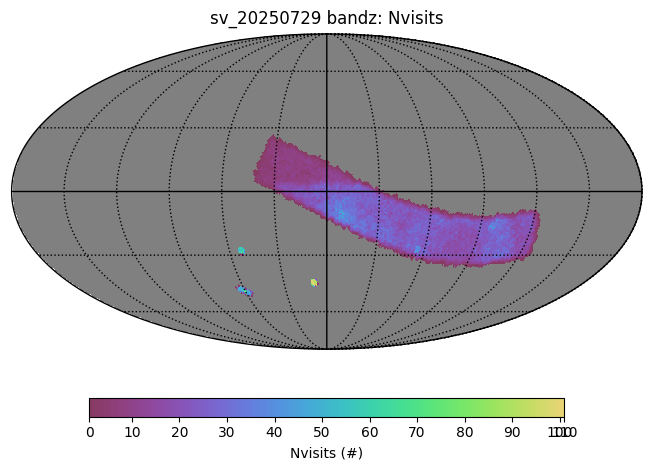

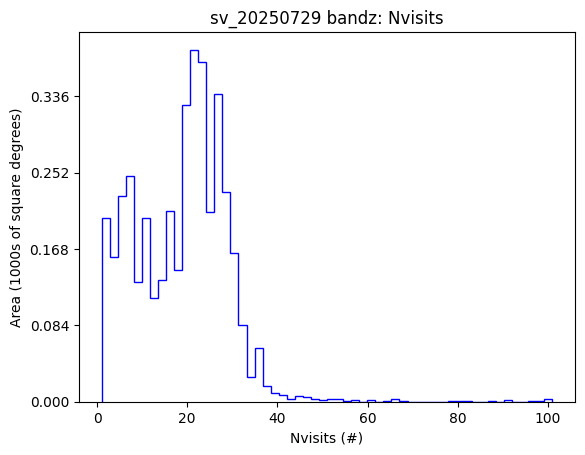

In [30]:
# Generate the standard sky plot of Nvisits per HEALpixels
zvisits_metric_bundle.plot()

## Visits to regions with different stellar densities.  

A key goal of the SV surveys for galactic science is to acquire adequate observations of fields with a range of stellar densities, in order to verify that these data can be properly reduced with the LSST pipeline.  

We can compare the metric data from the ops_db with a map of stellar density per HEALpixel to roughly evaluate the observations to date.  

In [34]:
# Firstly, extract a list of Nvisits for each HEALpixel. 
gvisits = np.array([x for x in gbg.bundle_dict[run_name + '_Nvisits_bandg_HEAL'].metric_values.data])
rvisits = np.array([x for x in rbg.bundle_dict[run_name + '_Nvisits_bandr_HEAL'].metric_values.data])
ivisits = np.array([x for x in ibg.bundle_dict[run_name + '_Nvisits_bandi_HEAL'].metric_values.data])
zvisits = np.array([x for x in zbg.bundle_dict[run_name + '_Nvisits_bandz_HEAL'].metric_values.data])

Accompanying the rubin_sim software are various pre-packaged datasets, including sky maps of stellar density based on TriLegal model data. 

In [35]:
SIM_DATA_DIR = '/Users/rstreet/rubin_sim_data/maps/StarMaps' 
TRIMAP_FILE = 'starDensity_z_nside_64.npz'

In [36]:
trimap_data = np.load(path.join(SIM_DATA_DIR, TRIMAP_FILE))

# This loads a (49152, 65) array containing the stellar density in magnitude bins
star_density = trimap_data['starDensity']
bins = np.array(trimap_data['bins'])

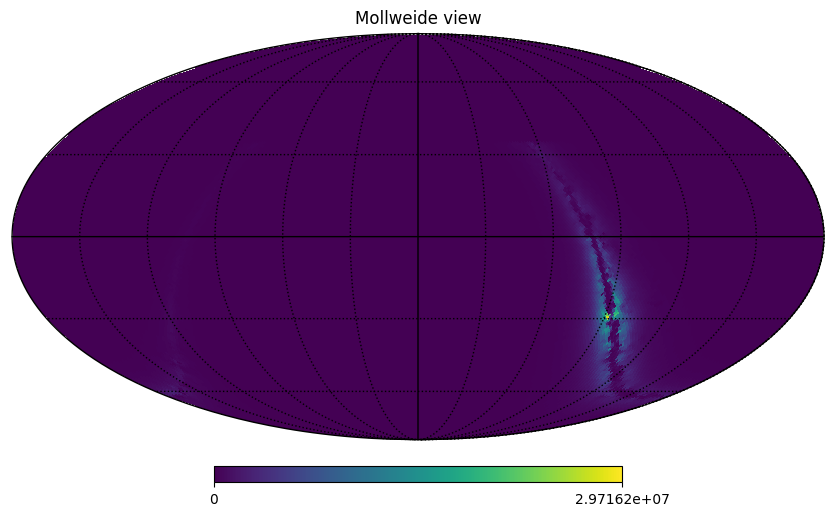

In [37]:
# Plot a sky map of the TriLegal star density given approximate LSST limiting magnitude in crowded fields
zlim = 15.2
idx1 = bins > 24.6
idx2 = bins < 25.0
idx = np.where(idx1 & idx2)[0][0]

hp.mollview(star_density[:,idx])
hp.graticule()

Now we can examine the range of stellar densities of the SV fields observed to date.

g [1. 1. 1. ... 1. 1. 1.]
r [1. 3. 2. ... 3. 4. 3.]
i [1. 3. 2. ... 1. 1. 1.]
z [ 2.  2.  2. ... 94. 94.  1.]


/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_34053/3244256112.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_xticklabels(xticklabels, fontsize=14)
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_34053/3244256112.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_yticklabels(yticklabels, fontsize=14)
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_34053/3244256112.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_xticklabels(xticklabels, fontsize=14)
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_34053/3244256112.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

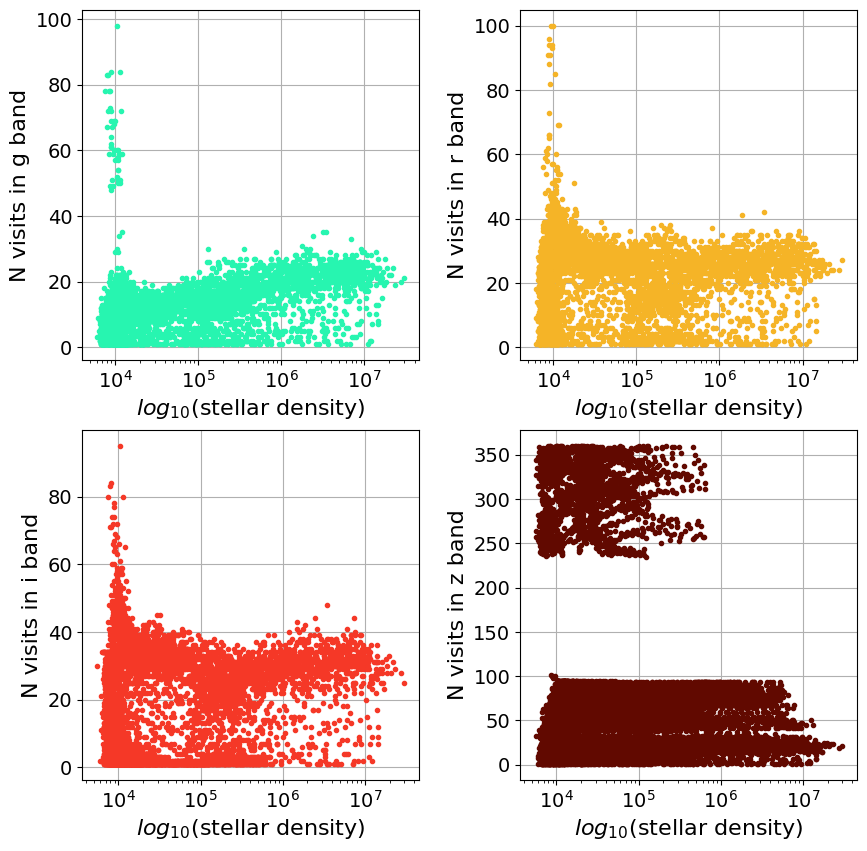

In [39]:
# Plot the number of visits as a function of stellar density 
fig, axs = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.3)

plot_colors = {
    'g': '#27F5B0',
    'r': '#F5B427', 
    'i': '#F53827',
    'z': '#610900'
}

nvisits = {
    'g': gvisits,
    'r': rvisits,
    'i': ivisits,
    'z': zvisits
}

row = 0
col = 0
for f, band_visits in nvisits.items():
    
    jdx = band_visits >= 1.0
    print(f, band_visits[jdx])
    
    axs[row,col].plot(star_density[jdx,idx], band_visits[jdx], marker='.', c=plot_colors[f], ls='none')
    
    axs[row,col].set_xscale('log')
    axs[row,col].set_ylabel('N visits in ' + f + ' band', fontsize=16)
    axs[row,col].set_xlabel('$log_{10}$(stellar density)', fontsize=16)
    xticklabels = axs[row,col].get_xticklabels()
    axs[row,col].set_xticklabels(xticklabels, fontsize=14)
    yticklabels = axs[row,col].get_yticklabels()
    axs[row,col].set_yticklabels(yticklabels, fontsize=14)
    axs[row,col].grid()

    col += 1
    if col > 1:
        row += 1
        col = 0